In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths
import sys

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training

BATCH_SIZE = 512

mixed_precision.set_global_policy('mixed_float16')


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-PCIE-32GB, compute capability 7.0


2022-05-30 01:43:25.029658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 01:43:25.068612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 01:43:25.070627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 01:43:25.105989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Empty                  5797
Morula                 1319
2pn                    1039
Syngamy                 834
4 Cell                  792
2 Cell                  736
Early blast             615
Compacting 8 cell       549
Expanded Blastocyst     394
8 Cell                  384
Blastocyst              374
6 Cell                  360
3 Cell                  303
5 Cell                  130
Name: class, dtype: int64

<AxesSubplot:>

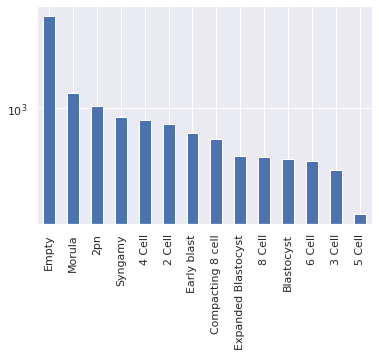

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: s.split("/")[-1].split("_")[:2]).value_counts()

[M0776, S00512]    1952
[M776, S0087]      1559
[M0776, S00635]    1294
[M0776, S00761]    1138
[M0776, S00534]    1102
[M0776, S00470]     784
Name: filename, dtype: int64

In [4]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
511                 2pn             1061
685             Syngamy             1464
298              2 Cell             1574
116              3 Cell             2315
104              4 Cell             2395
7                5 Cell             3045
29               6 Cell             3125
145              8 Cell             3265
24    Compacting 8 cell             3375
1169             Morula             4286
373         Early blast             5940
113          Blastocyst             6261
4850              Empty             7036


In [5]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Early blast',
 'Blastocyst',
 'Empty']

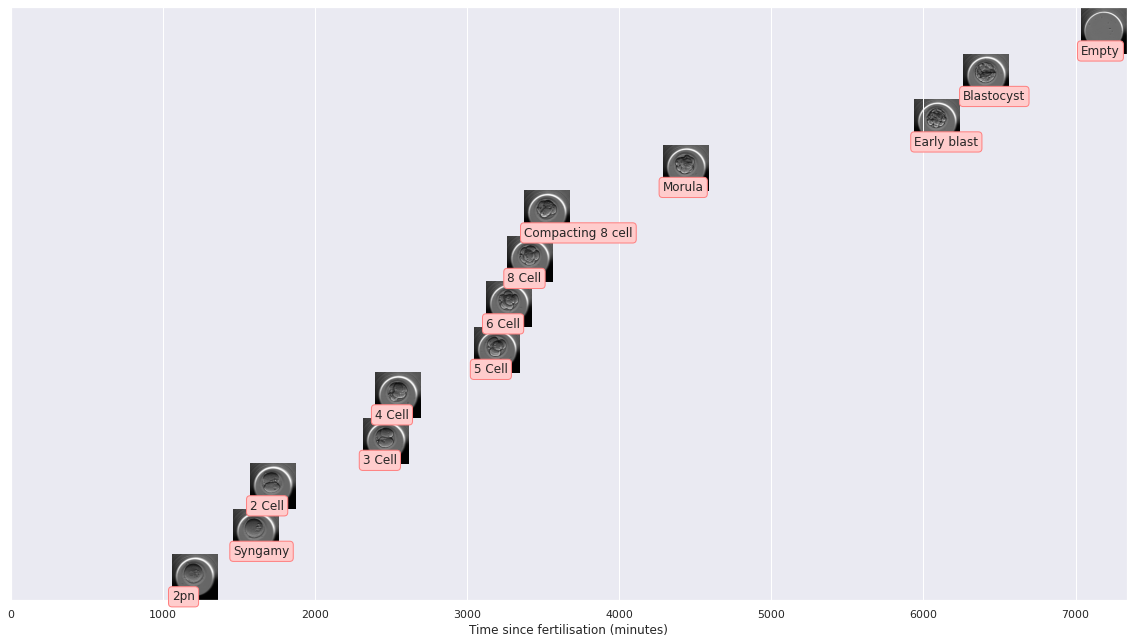

In [6]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

In [8]:
train=tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    image_size = (299,299),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
    shuffle = True
)

# 20% split between test/train here.
test_batches = tf.data.experimental.cardinality(train)
train_dataset = train.skip(test_batches // 5)
test_dataset = train.take(test_batches // 5)

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 13626 files belonging to 14 classes.
Number of train batches: 22
Number of test batches: 5


2022-05-30 01:43:33.078242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 01:43:33.079148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 01:43:33.079372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 01:43:33.079502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [67]:
len(train.file_paths[0:(test_batches // 5)*BATCH_SIZE])

2560

In [20]:
classes = train.class_names
classes

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Compacting 8 cell',
 'Early blast',
 'Empty',
 'Expanded Blastocyst',
 'Morula',
 'Syngamy']

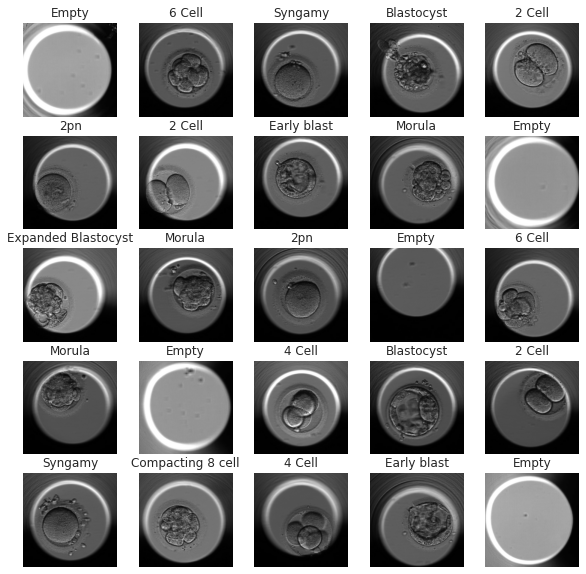

In [35]:
plt.figure(figsize=(10, 10))
images, labels = next(iter(train_dataset))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i] / 255)
    plt.title(classes[labels[i].numpy().argmax()])
    plt.axis("off")

In [39]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299,299,3),
    include_top=False)  # Do not include the ImageNet classifier at the top.


# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

random_flip = keras.layers.RandomFlip("horizontal_and_vertical")
x = random_flip(inputs)

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1./127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
#x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(len(classes), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 299, 299, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 14)                28686     
                                                           

In [40]:
%%time
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

CPU times: user 10.9 ms, sys: 4.76 ms, total: 15.7 ms
Wall time: 14 ms


In [42]:
%%time
history = model.fit(train_dataset,
                    epochs=500,
                    verbose=1,
                    validation_data=test_dataset,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=10, verbose=0),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/22           ETA: ?s - 

Epoch 1/500
22/22 [==============================] - 19s 852ms/step - loss: 0.5831 - categorical_accuracy: 0.8209 - val_loss: 0.5967 - val_categorical_accuracy: 0.8172
Epoch 2/500


0/22           ETA: ?s - 

Epoch 2/500
22/22 [==============================] - 19s 863ms/step - loss: 0.5658 - categorical_accuracy: 0.8279 - val_loss: 0.5802 - val_categorical_accuracy: 0.8230
Epoch 3/500


0/22           ETA: ?s - 

Epoch 3/500
22/22 [==============================] - 19s 853ms/step - loss: 0.5533 - categorical_accuracy: 0.8308 - val_loss: 0.5668 - val_categorical_accuracy: 0.8258
Epoch 4/500


0/22           ETA: ?s - 

Epoch 4/500
22/22 [==============================] - 19s 852ms/step - loss: 0.5366 - categorical_accuracy: 0.8344 - val_loss: 0.5528 - val_categorical_accuracy: 0.8320
Epoch 5/500


0/22           ETA: ?s - 

Epoch 5/500
22/22 [==============================] - 19s 853ms/step - loss: 0.5241 - categorical_accuracy: 0.8391 - val_loss: 0.5394 - val_categorical_accuracy: 0.8340
Epoch 6/500


0/22           ETA: ?s - 

Epoch 6/500
22/22 [==============================] - 19s 854ms/step - loss: 0.5161 - categorical_accuracy: 0.8395 - val_loss: 0.5289 - val_categorical_accuracy: 0.8375
Epoch 7/500


0/22           ETA: ?s - 

Epoch 7/500
22/22 [==============================] - 19s 854ms/step - loss: 0.5031 - categorical_accuracy: 0.8459 - val_loss: 0.5192 - val_categorical_accuracy: 0.8383
Epoch 8/500


0/22           ETA: ?s - 

Epoch 8/500
22/22 [==============================] - 19s 861ms/step - loss: 0.4952 - categorical_accuracy: 0.8471 - val_loss: 0.5079 - val_categorical_accuracy: 0.8430
Epoch 9/500


0/22           ETA: ?s - 

Epoch 9/500
22/22 [==============================] - 19s 862ms/step - loss: 0.4863 - categorical_accuracy: 0.8486 - val_loss: 0.4997 - val_categorical_accuracy: 0.8457
Epoch 10/500


0/22           ETA: ?s - 

Epoch 10/500
22/22 [==============================] - 19s 859ms/step - loss: 0.4786 - categorical_accuracy: 0.8502 - val_loss: 0.4918 - val_categorical_accuracy: 0.8465
Epoch 11/500


0/22           ETA: ?s - 

Epoch 11/500
22/22 [==============================] - 19s 871ms/step - loss: 0.4693 - categorical_accuracy: 0.8560 - val_loss: 0.4836 - val_categorical_accuracy: 0.8500
Epoch 12/500


0/22           ETA: ?s - 

Epoch 12/500
22/22 [==============================] - 19s 861ms/step - loss: 0.4591 - categorical_accuracy: 0.8593 - val_loss: 0.4757 - val_categorical_accuracy: 0.8535
Epoch 13/500


0/22           ETA: ?s - 

Epoch 13/500
22/22 [==============================] - 19s 851ms/step - loss: 0.4523 - categorical_accuracy: 0.8616 - val_loss: 0.4692 - val_categorical_accuracy: 0.8535
Epoch 14/500


0/22           ETA: ?s - 

Epoch 14/500
22/22 [==============================] - 19s 869ms/step - loss: 0.4466 - categorical_accuracy: 0.8646 - val_loss: 0.4619 - val_categorical_accuracy: 0.8562
Epoch 15/500


0/22           ETA: ?s - 

Epoch 15/500
22/22 [==============================] - 19s 874ms/step - loss: 0.4419 - categorical_accuracy: 0.8669 - val_loss: 0.4558 - val_categorical_accuracy: 0.8602
Epoch 16/500


0/22           ETA: ?s - 

Epoch 16/500
22/22 [==============================] - 19s 854ms/step - loss: 0.4318 - categorical_accuracy: 0.8692 - val_loss: 0.4487 - val_categorical_accuracy: 0.8605
Epoch 17/500


0/22           ETA: ?s - 

Epoch 17/500
22/22 [==============================] - 19s 854ms/step - loss: 0.4299 - categorical_accuracy: 0.8705 - val_loss: 0.4430 - val_categorical_accuracy: 0.8625
Epoch 18/500


0/22           ETA: ?s - 

Epoch 18/500
22/22 [==============================] - 19s 853ms/step - loss: 0.4214 - categorical_accuracy: 0.8710 - val_loss: 0.4369 - val_categorical_accuracy: 0.8629
Epoch 19/500


0/22           ETA: ?s - 

Epoch 19/500
22/22 [==============================] - 19s 866ms/step - loss: 0.4174 - categorical_accuracy: 0.8698 - val_loss: 0.4308 - val_categorical_accuracy: 0.8664
Epoch 20/500


0/22           ETA: ?s - 

Epoch 20/500
22/22 [==============================] - 19s 865ms/step - loss: 0.4079 - categorical_accuracy: 0.8762 - val_loss: 0.4260 - val_categorical_accuracy: 0.8645
Epoch 21/500


0/22           ETA: ?s - 

Epoch 21/500
22/22 [==============================] - 19s 851ms/step - loss: 0.4065 - categorical_accuracy: 0.8774 - val_loss: 0.4226 - val_categorical_accuracy: 0.8660
Epoch 22/500


0/22           ETA: ?s - 

Epoch 22/500
22/22 [==============================] - 19s 855ms/step - loss: 0.4022 - categorical_accuracy: 0.8802 - val_loss: 0.4174 - val_categorical_accuracy: 0.8711
Epoch 23/500


0/22           ETA: ?s - 

Epoch 23/500
22/22 [==============================] - 19s 880ms/step - loss: 0.3990 - categorical_accuracy: 0.8813 - val_loss: 0.4117 - val_categorical_accuracy: 0.8707
Epoch 24/500


0/22           ETA: ?s - 

Epoch 24/500
22/22 [==============================] - 19s 858ms/step - loss: 0.3937 - categorical_accuracy: 0.8811 - val_loss: 0.4070 - val_categorical_accuracy: 0.8738
Epoch 25/500


0/22           ETA: ?s - 

Epoch 25/500
22/22 [==============================] - 19s 863ms/step - loss: 0.3873 - categorical_accuracy: 0.8824 - val_loss: 0.4039 - val_categorical_accuracy: 0.8750
Epoch 26/500


0/22           ETA: ?s - 

Epoch 26/500
22/22 [==============================] - 19s 870ms/step - loss: 0.3837 - categorical_accuracy: 0.8837 - val_loss: 0.4015 - val_categorical_accuracy: 0.8742
Epoch 27/500


0/22           ETA: ?s - 

Epoch 27/500
22/22 [==============================] - 19s 867ms/step - loss: 0.3836 - categorical_accuracy: 0.8850 - val_loss: 0.3964 - val_categorical_accuracy: 0.8781
Epoch 28/500


0/22           ETA: ?s - 

Epoch 28/500
22/22 [==============================] - 19s 861ms/step - loss: 0.3775 - categorical_accuracy: 0.8878 - val_loss: 0.3917 - val_categorical_accuracy: 0.8785
Epoch 29/500


0/22           ETA: ?s - 

Epoch 29/500
22/22 [==============================] - 19s 853ms/step - loss: 0.3689 - categorical_accuracy: 0.8891 - val_loss: 0.3886 - val_categorical_accuracy: 0.8789
Epoch 30/500


0/22           ETA: ?s - 

Epoch 30/500
22/22 [==============================] - 19s 851ms/step - loss: 0.3683 - categorical_accuracy: 0.8873 - val_loss: 0.3842 - val_categorical_accuracy: 0.8824
Epoch 31/500


0/22           ETA: ?s - 

Epoch 31/500
22/22 [==============================] - 19s 849ms/step - loss: 0.3657 - categorical_accuracy: 0.8901 - val_loss: 0.3811 - val_categorical_accuracy: 0.8809
Epoch 32/500


0/22           ETA: ?s - 

Epoch 32/500
22/22 [==============================] - 19s 862ms/step - loss: 0.3614 - categorical_accuracy: 0.8935 - val_loss: 0.3769 - val_categorical_accuracy: 0.8813
Epoch 33/500


0/22           ETA: ?s - 

Epoch 33/500
22/22 [==============================] - 19s 857ms/step - loss: 0.3543 - categorical_accuracy: 0.8953 - val_loss: 0.3751 - val_categorical_accuracy: 0.8816
Epoch 34/500


0/22           ETA: ?s - 

Epoch 34/500
22/22 [==============================] - 19s 867ms/step - loss: 0.3530 - categorical_accuracy: 0.8960 - val_loss: 0.3700 - val_categorical_accuracy: 0.8824
Epoch 35/500


0/22           ETA: ?s - 

Epoch 35/500
22/22 [==============================] - 19s 853ms/step - loss: 0.3492 - categorical_accuracy: 0.8973 - val_loss: 0.3677 - val_categorical_accuracy: 0.8871
Epoch 36/500


0/22           ETA: ?s - 

Epoch 36/500
22/22 [==============================] - 19s 867ms/step - loss: 0.3501 - categorical_accuracy: 0.8951 - val_loss: 0.3642 - val_categorical_accuracy: 0.8879
Epoch 37/500


0/22           ETA: ?s - 

Epoch 37/500
22/22 [==============================] - 19s 871ms/step - loss: 0.3432 - categorical_accuracy: 0.8995 - val_loss: 0.3608 - val_categorical_accuracy: 0.8906
Epoch 38/500


0/22           ETA: ?s - 

Epoch 38/500
22/22 [==============================] - 19s 870ms/step - loss: 0.3423 - categorical_accuracy: 0.8962 - val_loss: 0.3568 - val_categorical_accuracy: 0.8930
Epoch 39/500


0/22           ETA: ?s - 

Epoch 39/500
22/22 [==============================] - 19s 857ms/step - loss: 0.3379 - categorical_accuracy: 0.8982 - val_loss: 0.3552 - val_categorical_accuracy: 0.8902
Epoch 40/500


0/22           ETA: ?s - 

Epoch 40/500
22/22 [==============================] - 19s 860ms/step - loss: 0.3352 - categorical_accuracy: 0.9010 - val_loss: 0.3533 - val_categorical_accuracy: 0.8918
Epoch 41/500


0/22           ETA: ?s - 

Epoch 41/500
22/22 [==============================] - 19s 857ms/step - loss: 0.3311 - categorical_accuracy: 0.9032 - val_loss: 0.3506 - val_categorical_accuracy: 0.8949
Epoch 42/500


0/22           ETA: ?s - 

Epoch 42/500
22/22 [==============================] - 19s 859ms/step - loss: 0.3312 - categorical_accuracy: 0.9013 - val_loss: 0.3471 - val_categorical_accuracy: 0.8941
Epoch 43/500


0/22           ETA: ?s - 

Epoch 43/500
22/22 [==============================] - 19s 850ms/step - loss: 0.3264 - categorical_accuracy: 0.9015 - val_loss: 0.3445 - val_categorical_accuracy: 0.8949
Epoch 44/500


0/22           ETA: ?s - 

Epoch 44/500
22/22 [==============================] - 19s 856ms/step - loss: 0.3258 - categorical_accuracy: 0.8997 - val_loss: 0.3411 - val_categorical_accuracy: 0.8941
Epoch 45/500


0/22           ETA: ?s - 

Epoch 45/500
22/22 [==============================] - 19s 861ms/step - loss: 0.3244 - categorical_accuracy: 0.9005 - val_loss: 0.3383 - val_categorical_accuracy: 0.8965
Epoch 46/500


0/22           ETA: ?s - 

Epoch 46/500
22/22 [==============================] - 19s 868ms/step - loss: 0.3206 - categorical_accuracy: 0.9047 - val_loss: 0.3359 - val_categorical_accuracy: 0.8988
Epoch 47/500


0/22           ETA: ?s - 

Epoch 47/500
22/22 [==============================] - 19s 862ms/step - loss: 0.3171 - categorical_accuracy: 0.9040 - val_loss: 0.3331 - val_categorical_accuracy: 0.8980
Epoch 48/500


0/22           ETA: ?s - 

Epoch 48/500
22/22 [==============================] - 19s 856ms/step - loss: 0.3124 - categorical_accuracy: 0.9058 - val_loss: 0.3321 - val_categorical_accuracy: 0.9012
Epoch 49/500


0/22           ETA: ?s - 

Epoch 49/500
22/22 [==============================] - 19s 874ms/step - loss: 0.3146 - categorical_accuracy: 0.9072 - val_loss: 0.3294 - val_categorical_accuracy: 0.8988
Epoch 50/500


0/22           ETA: ?s - 

Epoch 50/500
22/22 [==============================] - 19s 858ms/step - loss: 0.3098 - categorical_accuracy: 0.9096 - val_loss: 0.3276 - val_categorical_accuracy: 0.9012
Epoch 51/500


0/22           ETA: ?s - 

Epoch 51/500
22/22 [==============================] - 19s 854ms/step - loss: 0.3077 - categorical_accuracy: 0.9073 - val_loss: 0.3237 - val_categorical_accuracy: 0.9020
Epoch 52/500


0/22           ETA: ?s - 

Epoch 52/500
22/22 [==============================] - 19s 864ms/step - loss: 0.3098 - categorical_accuracy: 0.9061 - val_loss: 0.3221 - val_categorical_accuracy: 0.9031
Epoch 53/500


0/22           ETA: ?s - 

Epoch 53/500
22/22 [==============================] - 19s 872ms/step - loss: 0.3023 - categorical_accuracy: 0.9102 - val_loss: 0.3212 - val_categorical_accuracy: 0.9051
Epoch 54/500


0/22           ETA: ?s - 

Epoch 54/500
22/22 [==============================] - 19s 865ms/step - loss: 0.3010 - categorical_accuracy: 0.9104 - val_loss: 0.3169 - val_categorical_accuracy: 0.9039
Epoch 55/500


0/22           ETA: ?s - 

Epoch 55/500
22/22 [==============================] - 19s 860ms/step - loss: 0.3015 - categorical_accuracy: 0.9109 - val_loss: 0.3146 - val_categorical_accuracy: 0.9055
Epoch 56/500


0/22           ETA: ?s - 

Epoch 56/500
22/22 [==============================] - 19s 860ms/step - loss: 0.3002 - categorical_accuracy: 0.9123 - val_loss: 0.3154 - val_categorical_accuracy: 0.9086
Epoch 57/500


0/22           ETA: ?s - 

Epoch 57/500
22/22 [==============================] - 19s 860ms/step - loss: 0.2949 - categorical_accuracy: 0.9123 - val_loss: 0.3136 - val_categorical_accuracy: 0.9086
Epoch 58/500


0/22           ETA: ?s - 

Epoch 58/500
22/22 [==============================] - 19s 868ms/step - loss: 0.2965 - categorical_accuracy: 0.9128 - val_loss: 0.3107 - val_categorical_accuracy: 0.9098
Epoch 59/500


0/22           ETA: ?s - 

Epoch 59/500
22/22 [==============================] - 19s 858ms/step - loss: 0.2923 - categorical_accuracy: 0.9159 - val_loss: 0.3077 - val_categorical_accuracy: 0.9090
Epoch 60/500


0/22           ETA: ?s - 

Epoch 60/500
22/22 [==============================] - 19s 851ms/step - loss: 0.2913 - categorical_accuracy: 0.9124 - val_loss: 0.3077 - val_categorical_accuracy: 0.9078
Epoch 61/500


0/22           ETA: ?s - 

Epoch 61/500
22/22 [==============================] - 19s 854ms/step - loss: 0.2891 - categorical_accuracy: 0.9156 - val_loss: 0.3055 - val_categorical_accuracy: 0.9105
Epoch 62/500


0/22           ETA: ?s - 

Epoch 62/500
22/22 [==============================] - 19s 861ms/step - loss: 0.2876 - categorical_accuracy: 0.9135 - val_loss: 0.3025 - val_categorical_accuracy: 0.9109
Epoch 63/500


0/22           ETA: ?s - 

Epoch 63/500
22/22 [==============================] - 19s 877ms/step - loss: 0.2844 - categorical_accuracy: 0.9167 - val_loss: 0.3006 - val_categorical_accuracy: 0.9125
Epoch 64/500


0/22           ETA: ?s - 

Epoch 64/500
22/22 [==============================] - 19s 865ms/step - loss: 0.2819 - categorical_accuracy: 0.9177 - val_loss: 0.3000 - val_categorical_accuracy: 0.9109
Epoch 65/500


0/22           ETA: ?s - 

Epoch 65/500
22/22 [==============================] - 19s 855ms/step - loss: 0.2819 - categorical_accuracy: 0.9160 - val_loss: 0.2987 - val_categorical_accuracy: 0.9137
Epoch 66/500


0/22           ETA: ?s - 

Epoch 66/500
22/22 [==============================] - 19s 855ms/step - loss: 0.2810 - categorical_accuracy: 0.9168 - val_loss: 0.2978 - val_categorical_accuracy: 0.9129
Epoch 67/500


0/22           ETA: ?s - 

Epoch 67/500
22/22 [==============================] - 19s 851ms/step - loss: 0.2762 - categorical_accuracy: 0.9173 - val_loss: 0.2931 - val_categorical_accuracy: 0.9141
Epoch 68/500


0/22           ETA: ?s - 

Epoch 68/500
22/22 [==============================] - 19s 862ms/step - loss: 0.2753 - categorical_accuracy: 0.9169 - val_loss: 0.2919 - val_categorical_accuracy: 0.9141
Epoch 69/500


0/22           ETA: ?s - 

Epoch 69/500
22/22 [==============================] - 19s 852ms/step - loss: 0.2727 - categorical_accuracy: 0.9176 - val_loss: 0.2916 - val_categorical_accuracy: 0.9160
Epoch 70/500


0/22           ETA: ?s - 

Epoch 70/500
22/22 [==============================] - 19s 857ms/step - loss: 0.2710 - categorical_accuracy: 0.9196 - val_loss: 0.2916 - val_categorical_accuracy: 0.9160
Epoch 71/500


0/22           ETA: ?s - 

Epoch 71/500
22/22 [==============================] - 19s 856ms/step - loss: 0.2670 - categorical_accuracy: 0.9224 - val_loss: 0.2874 - val_categorical_accuracy: 0.9172
Epoch 72/500


0/22           ETA: ?s - 

Epoch 72/500
22/22 [==============================] - 19s 851ms/step - loss: 0.2688 - categorical_accuracy: 0.9216 - val_loss: 0.2860 - val_categorical_accuracy: 0.9156
Epoch 73/500


0/22           ETA: ?s - 

Epoch 73/500
22/22 [==============================] - 19s 849ms/step - loss: 0.2667 - categorical_accuracy: 0.9227 - val_loss: 0.2855 - val_categorical_accuracy: 0.9160
Epoch 74/500


0/22           ETA: ?s - 

Epoch 74/500
22/22 [==============================] - 19s 855ms/step - loss: 0.2661 - categorical_accuracy: 0.9233 - val_loss: 0.2842 - val_categorical_accuracy: 0.9145
Epoch 75/500


0/22           ETA: ?s - 

Epoch 75/500
22/22 [==============================] - 19s 847ms/step - loss: 0.2676 - categorical_accuracy: 0.9205 - val_loss: 0.2814 - val_categorical_accuracy: 0.9187
Epoch 76/500


0/22           ETA: ?s - 

Epoch 76/500
22/22 [==============================] - 19s 860ms/step - loss: 0.2621 - categorical_accuracy: 0.9239 - val_loss: 0.2805 - val_categorical_accuracy: 0.9195
Epoch 77/500


0/22           ETA: ?s - 

Epoch 77/500
22/22 [==============================] - 19s 852ms/step - loss: 0.2640 - categorical_accuracy: 0.9222 - val_loss: 0.2791 - val_categorical_accuracy: 0.9219
Epoch 78/500


0/22           ETA: ?s - 

Epoch 78/500
22/22 [==============================] - 19s 858ms/step - loss: 0.2632 - categorical_accuracy: 0.9223 - val_loss: 0.2778 - val_categorical_accuracy: 0.9199
Epoch 79/500


0/22           ETA: ?s - 

Epoch 79/500
22/22 [==============================] - 19s 861ms/step - loss: 0.2578 - categorical_accuracy: 0.9240 - val_loss: 0.2761 - val_categorical_accuracy: 0.9168
Epoch 80/500


0/22           ETA: ?s - 

Epoch 80/500
22/22 [==============================] - 19s 857ms/step - loss: 0.2559 - categorical_accuracy: 0.9259 - val_loss: 0.2752 - val_categorical_accuracy: 0.9191
Epoch 81/500


0/22           ETA: ?s - 

Epoch 81/500
22/22 [==============================] - 19s 854ms/step - loss: 0.2576 - categorical_accuracy: 0.9268 - val_loss: 0.2745 - val_categorical_accuracy: 0.9207
Epoch 82/500


0/22           ETA: ?s - 

Epoch 82/500
22/22 [==============================] - 19s 864ms/step - loss: 0.2525 - categorical_accuracy: 0.9271 - val_loss: 0.2719 - val_categorical_accuracy: 0.9184
Epoch 83/500


0/22           ETA: ?s - 

Epoch 83/500
22/22 [==============================] - 19s 855ms/step - loss: 0.2523 - categorical_accuracy: 0.9246 - val_loss: 0.2719 - val_categorical_accuracy: 0.9187
Epoch 84/500


0/22           ETA: ?s - 

Epoch 84/500
22/22 [==============================] - 19s 858ms/step - loss: 0.2524 - categorical_accuracy: 0.9270 - val_loss: 0.2694 - val_categorical_accuracy: 0.9184
Epoch 85/500


0/22           ETA: ?s - 

Epoch 85/500
22/22 [==============================] - 19s 853ms/step - loss: 0.2497 - categorical_accuracy: 0.9274 - val_loss: 0.2681 - val_categorical_accuracy: 0.9207
Epoch 86/500


0/22           ETA: ?s - 

Epoch 86/500
22/22 [==============================] - 19s 861ms/step - loss: 0.2509 - categorical_accuracy: 0.9263 - val_loss: 0.2680 - val_categorical_accuracy: 0.9219
Epoch 87/500


0/22           ETA: ?s - 

Epoch 87/500
22/22 [==============================] - 19s 854ms/step - loss: 0.2511 - categorical_accuracy: 0.9245 - val_loss: 0.2652 - val_categorical_accuracy: 0.9227
Epoch 88/500


0/22           ETA: ?s - 

Epoch 88/500
22/22 [==============================] - 19s 865ms/step - loss: 0.2469 - categorical_accuracy: 0.9293 - val_loss: 0.2640 - val_categorical_accuracy: 0.9215
Epoch 89/500


0/22           ETA: ?s - 

Epoch 89/500
22/22 [==============================] - 19s 859ms/step - loss: 0.2450 - categorical_accuracy: 0.9292 - val_loss: 0.2654 - val_categorical_accuracy: 0.9238
Epoch 90/500


0/22           ETA: ?s - 

Epoch 90/500
22/22 [==============================] - 19s 858ms/step - loss: 0.2455 - categorical_accuracy: 0.9297 - val_loss: 0.2643 - val_categorical_accuracy: 0.9254
Epoch 91/500


0/22           ETA: ?s - 

Epoch 91/500
22/22 [==============================] - 19s 848ms/step - loss: 0.2418 - categorical_accuracy: 0.9310 - val_loss: 0.2600 - val_categorical_accuracy: 0.9230
Epoch 92/500


0/22           ETA: ?s - 

Epoch 92/500
22/22 [==============================] - 19s 856ms/step - loss: 0.2417 - categorical_accuracy: 0.9274 - val_loss: 0.2587 - val_categorical_accuracy: 0.9227
Epoch 93/500


0/22           ETA: ?s - 

Epoch 93/500
22/22 [==============================] - 19s 849ms/step - loss: 0.2394 - categorical_accuracy: 0.9310 - val_loss: 0.2586 - val_categorical_accuracy: 0.9246
Epoch 94/500


0/22           ETA: ?s - 

Epoch 94/500
22/22 [==============================] - 19s 859ms/step - loss: 0.2402 - categorical_accuracy: 0.9303 - val_loss: 0.2574 - val_categorical_accuracy: 0.9250
Epoch 95/500


0/22           ETA: ?s - 

Epoch 95/500
22/22 [==============================] - 19s 855ms/step - loss: 0.2433 - categorical_accuracy: 0.9274 - val_loss: 0.2559 - val_categorical_accuracy: 0.9254
Epoch 96/500


0/22           ETA: ?s - 

Epoch 96/500
22/22 [==============================] - 19s 866ms/step - loss: 0.2378 - categorical_accuracy: 0.9301 - val_loss: 0.2553 - val_categorical_accuracy: 0.9254
Epoch 97/500


0/22           ETA: ?s - 

Epoch 97/500
22/22 [==============================] - 19s 851ms/step - loss: 0.2390 - categorical_accuracy: 0.9315 - val_loss: 0.2541 - val_categorical_accuracy: 0.9270
Epoch 98/500


0/22           ETA: ?s - 

Epoch 98/500
22/22 [==============================] - 19s 855ms/step - loss: 0.2356 - categorical_accuracy: 0.9302 - val_loss: 0.2529 - val_categorical_accuracy: 0.9266
Epoch 99/500


0/22           ETA: ?s - 

Epoch 99/500
22/22 [==============================] - 19s 859ms/step - loss: 0.2351 - categorical_accuracy: 0.9324 - val_loss: 0.2540 - val_categorical_accuracy: 0.9285
Epoch 100/500


0/22           ETA: ?s - 

Epoch 100/500
22/22 [==============================] - 19s 860ms/step - loss: 0.2349 - categorical_accuracy: 0.9313 - val_loss: 0.2517 - val_categorical_accuracy: 0.9270
Epoch 101/500


0/22           ETA: ?s - 

Epoch 101/500
22/22 [==============================] - 19s 854ms/step - loss: 0.2333 - categorical_accuracy: 0.9308 - val_loss: 0.2503 - val_categorical_accuracy: 0.9273
Epoch 102/500


0/22           ETA: ?s - 

Epoch 102/500
22/22 [==============================] - 19s 855ms/step - loss: 0.2325 - categorical_accuracy: 0.9317 - val_loss: 0.2484 - val_categorical_accuracy: 0.9270
Epoch 103/500


0/22           ETA: ?s - 

Epoch 103/500
22/22 [==============================] - 19s 859ms/step - loss: 0.2265 - categorical_accuracy: 0.9339 - val_loss: 0.2466 - val_categorical_accuracy: 0.9281
Epoch 104/500


0/22           ETA: ?s - 

Epoch 104/500
22/22 [==============================] - 19s 863ms/step - loss: 0.2303 - categorical_accuracy: 0.9325 - val_loss: 0.2464 - val_categorical_accuracy: 0.9270
Epoch 105/500


0/22           ETA: ?s - 

Epoch 105/500
22/22 [==============================] - 19s 861ms/step - loss: 0.2283 - categorical_accuracy: 0.9333 - val_loss: 0.2451 - val_categorical_accuracy: 0.9285
Epoch 106/500


0/22           ETA: ?s - 

Epoch 106/500
22/22 [==============================] - 19s 869ms/step - loss: 0.2284 - categorical_accuracy: 0.9320 - val_loss: 0.2453 - val_categorical_accuracy: 0.9289
Epoch 107/500


0/22           ETA: ?s - 

Epoch 107/500
22/22 [==============================] - 19s 861ms/step - loss: 0.2259 - categorical_accuracy: 0.9352 - val_loss: 0.2439 - val_categorical_accuracy: 0.9305
Epoch 108/500


0/22           ETA: ?s - 

Epoch 108/500
22/22 [==============================] - 19s 868ms/step - loss: 0.2290 - categorical_accuracy: 0.9316 - val_loss: 0.2419 - val_categorical_accuracy: 0.9289
Epoch 109/500


0/22           ETA: ?s - 

Epoch 109/500
22/22 [==============================] - 19s 873ms/step - loss: 0.2226 - categorical_accuracy: 0.9358 - val_loss: 0.2415 - val_categorical_accuracy: 0.9320
Epoch 110/500


0/22           ETA: ?s - 

Epoch 110/500
22/22 [==============================] - 19s 852ms/step - loss: 0.2236 - categorical_accuracy: 0.9348 - val_loss: 0.2403 - val_categorical_accuracy: 0.9293
Epoch 111/500


0/22           ETA: ?s - 

Epoch 111/500
22/22 [==============================] - 19s 876ms/step - loss: 0.2233 - categorical_accuracy: 0.9356 - val_loss: 0.2392 - val_categorical_accuracy: 0.9336
Epoch 112/500


0/22           ETA: ?s - 

Epoch 112/500
22/22 [==============================] - 19s 866ms/step - loss: 0.2207 - categorical_accuracy: 0.9382 - val_loss: 0.2392 - val_categorical_accuracy: 0.9289
Epoch 113/500


0/22           ETA: ?s - 

Epoch 113/500
22/22 [==============================] - 19s 847ms/step - loss: 0.2214 - categorical_accuracy: 0.9328 - val_loss: 0.2355 - val_categorical_accuracy: 0.9285
Epoch 114/500


0/22           ETA: ?s - 

Epoch 114/500
22/22 [==============================] - 19s 850ms/step - loss: 0.2226 - categorical_accuracy: 0.9337 - val_loss: 0.2357 - val_categorical_accuracy: 0.9297
Epoch 115/500


0/22           ETA: ?s - 

Epoch 115/500
22/22 [==============================] - 19s 872ms/step - loss: 0.2183 - categorical_accuracy: 0.9367 - val_loss: 0.2355 - val_categorical_accuracy: 0.9297
Epoch 116/500


0/22           ETA: ?s - 

Epoch 116/500
22/22 [==============================] - 19s 861ms/step - loss: 0.2169 - categorical_accuracy: 0.9359 - val_loss: 0.2342 - val_categorical_accuracy: 0.9309
Epoch 117/500


0/22           ETA: ?s - 

Epoch 117/500
22/22 [==============================] - 19s 851ms/step - loss: 0.2185 - categorical_accuracy: 0.9359 - val_loss: 0.2333 - val_categorical_accuracy: 0.9320
Epoch 118/500


0/22           ETA: ?s - 

Epoch 118/500
22/22 [==============================] - 18s 844ms/step - loss: 0.2145 - categorical_accuracy: 0.9391 - val_loss: 0.2334 - val_categorical_accuracy: 0.9297
Epoch 119/500


0/22           ETA: ?s - 

Epoch 119/500
22/22 [==============================] - 19s 876ms/step - loss: 0.2145 - categorical_accuracy: 0.9358 - val_loss: 0.2333 - val_categorical_accuracy: 0.9352
Epoch 120/500


0/22           ETA: ?s - 

Epoch 120/500
22/22 [==============================] - 19s 858ms/step - loss: 0.2139 - categorical_accuracy: 0.9382 - val_loss: 0.2323 - val_categorical_accuracy: 0.9332
Epoch 121/500


0/22           ETA: ?s - 

Epoch 121/500
22/22 [==============================] - 19s 861ms/step - loss: 0.2125 - categorical_accuracy: 0.9399 - val_loss: 0.2312 - val_categorical_accuracy: 0.9328
Epoch 122/500


0/22           ETA: ?s - 

Epoch 122/500
22/22 [==============================] - 19s 867ms/step - loss: 0.2103 - categorical_accuracy: 0.9401 - val_loss: 0.2289 - val_categorical_accuracy: 0.9332
Epoch 123/500


0/22           ETA: ?s - 

Epoch 123/500
22/22 [==============================] - 19s 872ms/step - loss: 0.2101 - categorical_accuracy: 0.9378 - val_loss: 0.2281 - val_categorical_accuracy: 0.9293
Epoch 124/500


0/22           ETA: ?s - 

Epoch 124/500
22/22 [==============================] - 19s 852ms/step - loss: 0.2096 - categorical_accuracy: 0.9385 - val_loss: 0.2293 - val_categorical_accuracy: 0.9316
Epoch 125/500


0/22           ETA: ?s - 

Epoch 125/500
22/22 [==============================] - 19s 856ms/step - loss: 0.2098 - categorical_accuracy: 0.9377 - val_loss: 0.2270 - val_categorical_accuracy: 0.9355
Epoch 126/500


0/22           ETA: ?s - 

Epoch 126/500
22/22 [==============================] - 19s 853ms/step - loss: 0.2090 - categorical_accuracy: 0.9385 - val_loss: 0.2265 - val_categorical_accuracy: 0.9359
Epoch 127/500


0/22           ETA: ?s - 

Epoch 127/500
22/22 [==============================] - 19s 853ms/step - loss: 0.2096 - categorical_accuracy: 0.9397 - val_loss: 0.2262 - val_categorical_accuracy: 0.9328
Epoch 128/500


0/22           ETA: ?s - 

Epoch 128/500
22/22 [==============================] - 19s 857ms/step - loss: 0.2096 - categorical_accuracy: 0.9392 - val_loss: 0.2241 - val_categorical_accuracy: 0.9355
Epoch 129/500


0/22           ETA: ?s - 

Epoch 129/500
22/22 [==============================] - 19s 850ms/step - loss: 0.2084 - categorical_accuracy: 0.9393 - val_loss: 0.2245 - val_categorical_accuracy: 0.9348
Epoch 130/500


0/22           ETA: ?s - 

Epoch 130/500
22/22 [==============================] - 19s 858ms/step - loss: 0.2051 - categorical_accuracy: 0.9374 - val_loss: 0.2226 - val_categorical_accuracy: 0.9332
Epoch 131/500


0/22           ETA: ?s - 

Epoch 131/500
22/22 [==============================] - 19s 848ms/step - loss: 0.2056 - categorical_accuracy: 0.9412 - val_loss: 0.2221 - val_categorical_accuracy: 0.9363
Epoch 132/500


0/22           ETA: ?s - 

Epoch 132/500
22/22 [==============================] - 19s 859ms/step - loss: 0.2043 - categorical_accuracy: 0.9415 - val_loss: 0.2232 - val_categorical_accuracy: 0.9363
Epoch 133/500


0/22           ETA: ?s - 

Epoch 133/500
22/22 [==============================] - 19s 859ms/step - loss: 0.2032 - categorical_accuracy: 0.9401 - val_loss: 0.2214 - val_categorical_accuracy: 0.9371
Epoch 134/500


0/22           ETA: ?s - 

Epoch 134/500
22/22 [==============================] - 19s 868ms/step - loss: 0.2026 - categorical_accuracy: 0.9425 - val_loss: 0.2197 - val_categorical_accuracy: 0.9371
Epoch 135/500


0/22           ETA: ?s - 

Epoch 135/500
22/22 [==============================] - 19s 861ms/step - loss: 0.2000 - categorical_accuracy: 0.9414 - val_loss: 0.2194 - val_categorical_accuracy: 0.9352
Epoch 136/500


0/22           ETA: ?s - 

Epoch 136/500
22/22 [==============================] - 19s 856ms/step - loss: 0.2032 - categorical_accuracy: 0.9402 - val_loss: 0.2178 - val_categorical_accuracy: 0.9355
Epoch 137/500


0/22           ETA: ?s - 

Epoch 137/500
22/22 [==============================] - 19s 859ms/step - loss: 0.2019 - categorical_accuracy: 0.9404 - val_loss: 0.2180 - val_categorical_accuracy: 0.9371
Epoch 138/500


0/22           ETA: ?s - 

Epoch 138/500
22/22 [==============================] - 19s 857ms/step - loss: 0.1995 - categorical_accuracy: 0.9419 - val_loss: 0.2164 - val_categorical_accuracy: 0.9355
Epoch 139/500


0/22           ETA: ?s - 

Epoch 139/500
22/22 [==============================] - 19s 854ms/step - loss: 0.1990 - categorical_accuracy: 0.9430 - val_loss: 0.2161 - val_categorical_accuracy: 0.9363
Epoch 140/500


0/22           ETA: ?s - 

Epoch 140/500
22/22 [==============================] - 19s 869ms/step - loss: 0.1998 - categorical_accuracy: 0.9415 - val_loss: 0.2155 - val_categorical_accuracy: 0.9379
Epoch 141/500


0/22           ETA: ?s - 

Epoch 141/500
22/22 [==============================] - 19s 848ms/step - loss: 0.2001 - categorical_accuracy: 0.9418 - val_loss: 0.2148 - val_categorical_accuracy: 0.9379
Epoch 142/500


0/22           ETA: ?s - 

Epoch 142/500
22/22 [==============================] - 19s 855ms/step - loss: 0.1969 - categorical_accuracy: 0.9419 - val_loss: 0.2146 - val_categorical_accuracy: 0.9375
Epoch 143/500


0/22           ETA: ?s - 

Epoch 143/500
22/22 [==============================] - 19s 851ms/step - loss: 0.1957 - categorical_accuracy: 0.9423 - val_loss: 0.2130 - val_categorical_accuracy: 0.9359
Epoch 144/500


0/22           ETA: ?s - 

Epoch 144/500
22/22 [==============================] - 19s 849ms/step - loss: 0.1957 - categorical_accuracy: 0.9424 - val_loss: 0.2125 - val_categorical_accuracy: 0.9355
Epoch 145/500


0/22           ETA: ?s - 

Epoch 145/500
22/22 [==============================] - 19s 854ms/step - loss: 0.1946 - categorical_accuracy: 0.9462 - val_loss: 0.2121 - val_categorical_accuracy: 0.9387
Epoch 146/500


0/22           ETA: ?s - 

Epoch 146/500
22/22 [==============================] - 19s 845ms/step - loss: 0.1946 - categorical_accuracy: 0.9447 - val_loss: 0.2120 - val_categorical_accuracy: 0.9371
Epoch 147/500


0/22           ETA: ?s - 

Epoch 147/500
22/22 [==============================] - 19s 852ms/step - loss: 0.1940 - categorical_accuracy: 0.9425 - val_loss: 0.2110 - val_categorical_accuracy: 0.9367
Epoch 148/500


0/22           ETA: ?s - 

Epoch 148/500
22/22 [==============================] - 19s 849ms/step - loss: 0.1915 - categorical_accuracy: 0.9461 - val_loss: 0.2092 - val_categorical_accuracy: 0.9395
Epoch 149/500


0/22           ETA: ?s - 

Epoch 149/500
22/22 [==============================] - 19s 856ms/step - loss: 0.1907 - categorical_accuracy: 0.9446 - val_loss: 0.2092 - val_categorical_accuracy: 0.9363
Epoch 150/500


0/22           ETA: ?s - 

Epoch 150/500
22/22 [==============================] - 19s 846ms/step - loss: 0.1912 - categorical_accuracy: 0.9454 - val_loss: 0.2081 - val_categorical_accuracy: 0.9371
Epoch 151/500


0/22           ETA: ?s - 

Epoch 151/500
22/22 [==============================] - 19s 852ms/step - loss: 0.1926 - categorical_accuracy: 0.9425 - val_loss: 0.2076 - val_categorical_accuracy: 0.9383
Epoch 152/500


0/22           ETA: ?s - 

Epoch 152/500
22/22 [==============================] - 19s 855ms/step - loss: 0.1903 - categorical_accuracy: 0.9451 - val_loss: 0.2070 - val_categorical_accuracy: 0.9383
Epoch 153/500


0/22           ETA: ?s - 

Epoch 153/500
22/22 [==============================] - 19s 868ms/step - loss: 0.1898 - categorical_accuracy: 0.9452 - val_loss: 0.2058 - val_categorical_accuracy: 0.9387
Epoch 154/500


0/22           ETA: ?s - 

Epoch 154/500
22/22 [==============================] - 19s 853ms/step - loss: 0.1902 - categorical_accuracy: 0.9453 - val_loss: 0.2042 - val_categorical_accuracy: 0.9379
Epoch 155/500


0/22           ETA: ?s - 

Epoch 155/500
22/22 [==============================] - 19s 853ms/step - loss: 0.1901 - categorical_accuracy: 0.9451 - val_loss: 0.2066 - val_categorical_accuracy: 0.9383
Epoch 156/500


0/22           ETA: ?s - 

Epoch 156/500
22/22 [==============================] - 19s 851ms/step - loss: 0.1883 - categorical_accuracy: 0.9455 - val_loss: 0.2044 - val_categorical_accuracy: 0.9406
Epoch 157/500


0/22           ETA: ?s - 

Epoch 157/500
22/22 [==============================] - 19s 860ms/step - loss: 0.1873 - categorical_accuracy: 0.9455 - val_loss: 0.2042 - val_categorical_accuracy: 0.9410
Epoch 158/500


0/22           ETA: ?s - 

Epoch 158/500
22/22 [==============================] - 19s 856ms/step - loss: 0.1881 - categorical_accuracy: 0.9449 - val_loss: 0.2028 - val_categorical_accuracy: 0.9375
Epoch 159/500


0/22           ETA: ?s - 

Epoch 159/500
22/22 [==============================] - 19s 862ms/step - loss: 0.1879 - categorical_accuracy: 0.9474 - val_loss: 0.2038 - val_categorical_accuracy: 0.9395
Epoch 160/500


0/22           ETA: ?s - 

Epoch 160/500
22/22 [==============================] - 19s 872ms/step - loss: 0.1857 - categorical_accuracy: 0.9450 - val_loss: 0.2021 - val_categorical_accuracy: 0.9383
Epoch 161/500


0/22           ETA: ?s - 

Epoch 161/500
22/22 [==============================] - 19s 856ms/step - loss: 0.1826 - categorical_accuracy: 0.9482 - val_loss: 0.2010 - val_categorical_accuracy: 0.9371
Epoch 162/500


0/22           ETA: ?s - 

Epoch 162/500
22/22 [==============================] - 19s 868ms/step - loss: 0.1820 - categorical_accuracy: 0.9486 - val_loss: 0.2011 - val_categorical_accuracy: 0.9395
Epoch 163/500


0/22           ETA: ?s - 

Epoch 163/500
22/22 [==============================] - 19s 864ms/step - loss: 0.1861 - categorical_accuracy: 0.9479 - val_loss: 0.2008 - val_categorical_accuracy: 0.9391
Epoch 164/500


0/22           ETA: ?s - 

Epoch 164/500
22/22 [==============================] - 19s 863ms/step - loss: 0.1862 - categorical_accuracy: 0.9450 - val_loss: 0.1997 - val_categorical_accuracy: 0.9426
Epoch 165/500


0/22           ETA: ?s - 

Epoch 165/500
22/22 [==============================] - 19s 855ms/step - loss: 0.1827 - categorical_accuracy: 0.9477 - val_loss: 0.2002 - val_categorical_accuracy: 0.9410
Epoch 166/500


0/22           ETA: ?s - 

Epoch 166/500
22/22 [==============================] - 19s 857ms/step - loss: 0.1805 - categorical_accuracy: 0.9475 - val_loss: 0.1992 - val_categorical_accuracy: 0.9406
Epoch 167/500


0/22           ETA: ?s - 

Epoch 167/500
22/22 [==============================] - 19s 855ms/step - loss: 0.1829 - categorical_accuracy: 0.9474 - val_loss: 0.1994 - val_categorical_accuracy: 0.9414
Epoch 168/500


0/22           ETA: ?s - 

Epoch 168/500
22/22 [==============================] - 19s 849ms/step - loss: 0.1785 - categorical_accuracy: 0.9498 - val_loss: 0.1985 - val_categorical_accuracy: 0.9414
Epoch 169/500


0/22           ETA: ?s - 

Epoch 169/500
22/22 [==============================] - 19s 852ms/step - loss: 0.1793 - categorical_accuracy: 0.9484 - val_loss: 0.1967 - val_categorical_accuracy: 0.9449
Epoch 170/500


0/22           ETA: ?s - 

Epoch 170/500
22/22 [==============================] - 19s 848ms/step - loss: 0.1765 - categorical_accuracy: 0.9499 - val_loss: 0.1959 - val_categorical_accuracy: 0.9438
Epoch 171/500


0/22           ETA: ?s - 

Epoch 171/500
22/22 [==============================] - 19s 857ms/step - loss: 0.1785 - categorical_accuracy: 0.9500 - val_loss: 0.1958 - val_categorical_accuracy: 0.9438
Epoch 172/500


0/22           ETA: ?s - 

Epoch 172/500
22/22 [==============================] - 19s 856ms/step - loss: 0.1787 - categorical_accuracy: 0.9505 - val_loss: 0.1960 - val_categorical_accuracy: 0.9449
Epoch 173/500


0/22           ETA: ?s - 

Epoch 173/500
22/22 [==============================] - 19s 880ms/step - loss: 0.1779 - categorical_accuracy: 0.9505 - val_loss: 0.1954 - val_categorical_accuracy: 0.9410
Epoch 174/500


0/22           ETA: ?s - 

Epoch 174/500
22/22 [==============================] - 19s 848ms/step - loss: 0.1776 - categorical_accuracy: 0.9487 - val_loss: 0.1950 - val_categorical_accuracy: 0.9402
Epoch 175/500


0/22           ETA: ?s - 

Epoch 175/500
22/22 [==============================] - 19s 860ms/step - loss: 0.1766 - categorical_accuracy: 0.9493 - val_loss: 0.1948 - val_categorical_accuracy: 0.9426
Epoch 176/500


0/22           ETA: ?s - 

Epoch 176/500
22/22 [==============================] - 19s 865ms/step - loss: 0.1758 - categorical_accuracy: 0.9513 - val_loss: 0.1944 - val_categorical_accuracy: 0.9418
Epoch 177/500


0/22           ETA: ?s - 

Epoch 177/500
22/22 [==============================] - 19s 851ms/step - loss: 0.1756 - categorical_accuracy: 0.9503 - val_loss: 0.1934 - val_categorical_accuracy: 0.9441
Epoch 178/500


0/22           ETA: ?s - 

Epoch 178/500
22/22 [==============================] - 19s 848ms/step - loss: 0.1735 - categorical_accuracy: 0.9497 - val_loss: 0.1939 - val_categorical_accuracy: 0.9387
Epoch 179/500


0/22           ETA: ?s - 

Epoch 179/500
22/22 [==============================] - 19s 853ms/step - loss: 0.1759 - categorical_accuracy: 0.9488 - val_loss: 0.1940 - val_categorical_accuracy: 0.9414


<AxesSubplot:>

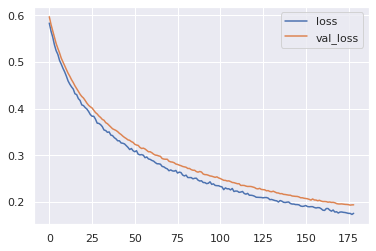

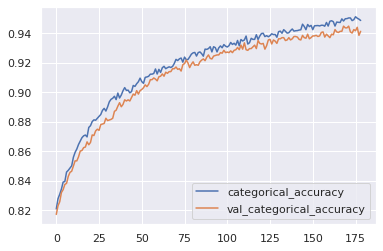

In [43]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [45]:
y_pred = model.predict(test_dataset)

5/5 [==============================] - 3s 498ms/step


In [46]:
predicted_codes = y_pred.argmax(axis=1)
confidence = y_pred.max(axis=1)
pd.Series(confidence).describe()

count    2560.000000
mean        0.893555
std         0.159912
min         0.257568
25%         0.838501
50%         0.983398
75%         1.000000
max         1.000000
dtype: float64

In [78]:
true_classes = []
for x,y in test_dataset:
    true_classes.extend(classes[c] for c in y.numpy().argmax(axis=1))
true_classes

['Morula',
 'Empty',
 'Empty',
 'Syngamy',
 'Empty',
 'Empty',
 'Compacting 8 cell',
 'Morula',
 'Empty',
 'Empty',
 'Blastocyst',
 '4 Cell',
 '2pn',
 'Morula',
 'Morula',
 'Early blast',
 'Empty',
 'Compacting 8 cell',
 'Empty',
 '2pn',
 'Syngamy',
 'Empty',
 'Empty',
 'Empty',
 'Early blast',
 '8 Cell',
 'Empty',
 'Empty',
 'Expanded Blastocyst',
 '2 Cell',
 'Morula',
 'Morula',
 '4 Cell',
 'Empty',
 'Empty',
 'Compacting 8 cell',
 '2pn',
 'Morula',
 'Empty',
 '4 Cell',
 'Empty',
 'Empty',
 'Empty',
 '5 Cell',
 'Compacting 8 cell',
 '4 Cell',
 'Syngamy',
 'Blastocyst',
 'Empty',
 '6 Cell',
 'Blastocyst',
 'Expanded Blastocyst',
 'Empty',
 '2 Cell',
 '4 Cell',
 '4 Cell',
 'Empty',
 'Morula',
 'Morula',
 'Empty',
 '3 Cell',
 'Empty',
 'Empty',
 'Empty',
 'Morula',
 'Blastocyst',
 'Empty',
 '2pn',
 '2pn',
 'Morula',
 '3 Cell',
 'Morula',
 'Morula',
 'Empty',
 'Syngamy',
 'Empty',
 'Empty',
 'Morula',
 'Syngamy',
 'Morula',
 'Empty',
 'Empty',
 'Morula',
 '2pn',
 'Early blast',
 'Empty',

In [80]:
validation_df = pd.DataFrame()
#validation_df["filepath"] = train.file_paths[0:(test_batches // 5)*BATCH_SIZE]
validation_df["true_class"] = true_classes
validation_df["predicted_class"] = [classes[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,true_class,predicted_class,confidence
0,Morula,Morula,0.935547
1,Empty,Empty,0.998535
2,Empty,Empty,1.000000
3,Syngamy,Syngamy,0.958008
4,Empty,Empty,1.000000
...,...,...,...
2555,Empty,Empty,0.999512
2556,Empty,Empty,0.999023
2557,Early blast,Early blast,0.987793
2558,Empty,Empty,0.999023


In [81]:
validation_df.groupby("predicted_class").confidence.median()

predicted_class
2 Cell                 0.949707
2pn                    0.961426
3 Cell                 0.825684
4 Cell                 0.908691
5 Cell                 0.706055
6 Cell                 0.783203
8 Cell                 0.738281
Blastocyst             0.776367
Compacting 8 cell      0.657715
Early blast            0.837402
Empty                  1.000000
Expanded Blastocyst    0.944336
Morula                 0.845215
Syngamy                0.915039
Name: confidence, dtype: float16

In [82]:
validation_df.to_csv("validation_predictions.csv", index=False)

                     precision    recall  f1-score   support

             2 Cell       0.91      0.96      0.94       132
                2pn       0.93      0.95      0.94       192
             3 Cell       0.95      0.82      0.88        68
             4 Cell       0.92      0.92      0.92       145
             5 Cell       0.84      0.59      0.70        27
             6 Cell       0.81      0.87      0.84        62
             8 Cell       0.88      0.89      0.89        65
         Blastocyst       0.85      0.80      0.82        70
  Compacting 8 cell       0.88      0.75      0.81       106
        Early blast       0.83      0.85      0.84       100
              Empty       1.00      1.00      1.00      1090
Expanded Blastocyst       0.92      0.91      0.91        75
             Morula       0.88      0.95      0.92       257
            Syngamy       0.95      0.94      0.94       171

           accuracy                           0.94      2560
          macro avg   

Text(30.499999999999993, 0.5, 'True')

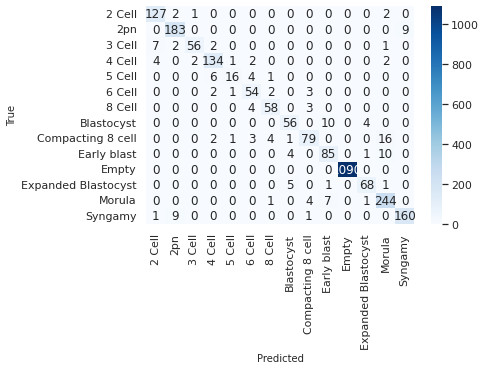

In [84]:
print(classification_report(validation_df["true_class"], validation_df["predicted_class"]))
s = sns.heatmap(
    confusion_matrix(validation_df["true_class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=classes,
    yticklabels=classes
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [85]:
model.save(f"models/{len(classes)}_class.h5")

In [91]:
test = tf.keras.utils.image_dataset_from_directory(
    "EmbryoLabeling/Labelers/One/M3169_S00470",
    labels=None,
    image_size = (299,299),
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 3591 files belonging to 1 classes.


In [92]:
results = model.predict(test)

8/8 [==============================] - 7s 816ms/step


In [93]:
predicted_codes = results.argmax(axis=1)
confidence = results.max(axis=1)
pd.Series(confidence).describe()

count    3591.000000
mean        0.646484
std         0.200195
min         0.182495
25%         0.479980
50%         0.637207
75%         0.814697
max         1.000000
dtype: float64

In [95]:
test_df = pd.DataFrame()
test_df["filepath"] = test.file_paths
test_df["class"] = [classes[c] for c in predicted_codes]
test_df["confidence"] = confidence
test_df

,filepath,class,confidence
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1010.jpg,2pn,0.963867
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1031.jpg,2pn,0.989258
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1052.jpg,2pn,0.991211
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1073.jpg,2pn,0.991699
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1094.jpg,2pn,0.976074
...,...,...,...
3586,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_990.jpg,Syngamy,0.657715
3587,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9921.jpg,Empty,0.653809
3588,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9942.jpg,Empty,0.511719
3589,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9963.jpg,Empty,0.511230


In [96]:
test_df["class"].value_counts()

2pn                    1009
Morula                  662
Empty                   562
Expanded Blastocyst     545
Syngamy                 378
5 Cell                  146
2 Cell                  111
4 Cell                  106
Blastocyst               65
Early blast               5
6 Cell                    2
Name: class, dtype: int64

In [97]:
test_df

,filepath,class,confidence
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1010.jpg,2pn,0.963867
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1031.jpg,2pn,0.989258
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1052.jpg,2pn,0.991211
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1073.jpg,2pn,0.991699
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1094.jpg,2pn,0.976074
...,...,...,...
3586,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_990.jpg,Syngamy,0.657715
3587,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9921.jpg,Empty,0.653809
3588,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9942.jpg,Empty,0.511719
3589,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9963.jpg,Empty,0.511230


In [98]:
test_df.to_csv("predictions.csv", index=False)